# Natural Computing - Project - DEAPWANN
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the [DEAP framework](https://github.com/deap/deap), which is an intuitive framework for evolutionary algorithms and genetic programming. We adapted several components of this framework to match more closely with the [WANN implementation](https://github.com/google/brain-tokyo-workshop/tree/master/WANNRelease).

## Imports

In [1]:
# DEAP
from deap import gp, base, tools, creator, algorithms

# Data processing and plotting
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Requirements for the algorithm
from operator import attrgetter
from functools import partial

# Standard python imports
import random, pickle, math, re, os
import numpy as np

# Magic for inline plots
%matplotlib inline

## Helper functions

In [2]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

## Global parameters

In [3]:
# Dataset
DATASET = "Fashion-MNIST" # choose from {"MNIST", "Fashion-MNIST"} 
N_CLASSES_TO_USE = 10 # at most 10

# Individual trees
P_INITIAL_CONNECTION = 0.05

# Fitness
SAMPLE_SIZE = 200
WEIGHTS_TO_TEST = [-2, -1, 1, 2] # -0.5 and 0.5 are not used due to long runtime

# Parent selection
TOURNAMENT_SIZE = 32

# Mutation (probabilities should sum to 1)
P_MUTATE_ACTIVATION = 0.5
P_ADD_NODE = 0.25
P_ADD_CONNECTION = 0.2
P_ENABLE_CONNECTION = 0.05

# Evolution
POPULATION_SIZE = 250
N_GENERATIONS = 1000
CULL_RATIO = 0.2
ELITE_RATIO = 0.2

# Filenames
N_CHECKPOINTS = 100
RESULTS_FILENAME = f"DEAPWANN-{DATASET}-results.pkl"

## Loading preprocessed data

In [4]:
# Set the correct data filename
filename = f"{DATASET}-{N_CLASSES_TO_USE}.pkl"

# If the data has not yet been preprocessed in the specified way, do so now
if not os.path.exists(os.path.join("data", filename)):
    print("Preprocessed dataset does not exist yet, creating now.")
    os.system(f"python Preprocessing.py -d {DATASET} -c {N_CLASSES_TO_USE}")

# Load the preprocessed data
with open(os.path.join("data", filename), "rb") as f:
    (X_train, Y_train), (X_test, Y_test) = pickle.load(f)

## Defining operators

In [5]:
# Define aggregator (weighted sum)
def aggregate(w, args):
    return w*sum(args)

# Define operators (with a variable number of inputs)
def linear(w, *args):
    return aggregate(w, args)

def step(w, *args):
    return float(aggregate(w, args) > 0)

def sine(w, *args):
    return np.sin(np.pi*aggregate(w, args))

def gaussian(w, *args):
    return exp(-np.multiply(aggregate(w, args), aggregate(w, args))/2.0)

def tanh(w, *args):
    return np.tanh(aggregate(w, args))

def sigmoid(w, *args):
    return (np.tanh(aggregate(w, args)/2.0) + 1.0)/2.0

def inverse(w, *args):
    return -aggregate(w, args)

def absolute(w, *args):
    return abs(aggregate(w, args))

def relu(w, *args):
    return np.maximum(0.0, aggregate(w, args))

def cosine(w, *args):
    return np.cos(np.pi*aggregate(w, args))

In [6]:
# Define dictionary of functions for compiling
function_context = {'linear':linear, 'relu':relu, 'step':step, 'sine':sine, 'gaussian':gaussian, 'tanh':tanh,  
                    'sigmoid':sigmoid, 'inverse':inverse, 'absolute':absolute, 'cosine':cosine}

# Create lists of function and argument names
function_names = list(function_context.keys())
argument_names = [f"ARG{i}" for i in range(X_train.shape[1])]

## Defining individuals

##### Defining nodes

In [7]:
# Generic Node class
class Node:
    def __init__(self, name):
        # Each node has a name and a list of parents
        self.name = name
        self.parents = []
    
    def __str__(self):
        raise NotImplementedError("String function is only implemented for subclasses")

# Class for terminal nodes (inputs)
class TerminalNode(Node):
    def __init__(self, name):
        super().__init__(name)

    def __str__(self):
        # Terminal nodes are simply formatted as their name (e.g. "ARG42")
        return self.name

# Class for non-terminal nodes (hidden + outputs)
class NonterminalNode(Node):
    def __init__(self, name):
        # Non-terminal nodes also have lists of children and disabled children
        super().__init__(name)
        self.children = []
        self.disabled = []

    def __str__(self):
        # Non-terminal nodes are formatted as "name(child1, child2, ...)"
        return f"{self.name}(w, {', '.join([str(child) for child in self.children])})"

##### Defining individuals/multi-class trees

In [8]:
# Class for multi-output trees
class MultiClassTree:
    def __init__(self, n_inputs, n_outputs, p_initial_connection):
        # Initialize lists of input, output and internal nodes
        self.inputs = [TerminalNode(argument_names[i]) for i in range(n_inputs)]
        self.outputs = [NonterminalNode("linear") for _ in range(n_outputs)]
        self.hidden = []
        self.born = -1
        
        # Add initial connections
        self.n_connections = 0
        for output in self.outputs:
            # With a chance of P_INITIAL_CONNECTION, the connection is enabled, otherwhise it is disabled
            for child in self.inputs:
                if random.random() < P_INITIAL_CONNECTION:
                    output.children.append(child)
                else:
                    output.disabled.append(child)
                child.parents.append(output)
                
            # If an output has no enabled children, one of the children is enabled to make the tree valid
            if not output.children:
                child = random.choice(self.inputs)
                output.disabled.remove(child)
                output.children.append(child)
            
            # Update the number of enabled connections in the tree
            self.n_connections += len(output.children)

    def __str__(self):
        # Printing the tree only prints the number of hidden nodes and enabled connections
        return f"MultiClassTree with {len(self.hidden)} hidden nodes and {self.n_connections} connections"\
                + (f", born in generation {self.born}" if self.born >= 0 else "")
    
    def get_strings(self):
         # (Recursively) parsing output function strings, to parse the tree for evaluation
        try:
            return [str(output) for output in self.outputs]
        except RecursionError:
            print("Maximum recursion depth reached")
            return None

##### Initializing the DEAP toolbox

In [9]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

In [10]:
# Define classes for fitness and individuals (using DEAP's creator module)
creator.create("Fitness", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", MultiClassTree, fitness=creator.Fitness, rank=-1) # An individual is a multi-class tree

In [11]:
# Define how to initialize an individual or population
toolbox.register("individual", creator.Individual, X_train.shape[1], N_CLASSES_TO_USE, P_INITIAL_CONNECTION)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Fitness function

##### Compiling multi-class trees into functions

In [12]:
# Compiling a tree into a function
def compile_multiclasstree(tree):
    # Parse trees to strings for all outputs
    strings = tree.get_strings()
    
    # Convert the string to lambda functions using eval() and the proper function context
    funcs = [eval(f"lambda w, {', '.join(argument_names)}: {string}", function_context, {}) for string in strings]
    
    # Create the function, which applies softmax over the outputs of the created lambda functions
    def func(w, args):
        def _softmax(x):
            return exp(x)/np.sum(exp(x), axis=0)
        return _softmax([f(w, *args) for f in funcs])
    
    # Return the created function
    return func

In [13]:
# Add the compile function to toolbox
toolbox.register("compile", compile_multiclasstree)

##### Defining the fitness function

In [14]:
def get_sample(sample_size):
    # Create a list of indices of samples to test, ensuring an equal number of samples from each class
    sample_indices = []
    samples_per_class = int(sample_size/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:samples_per_class])
    
    # Return the list of sample indices
    return sample_indices

In [15]:
# Define fitness function (cross-entropy loss & inversed number of connections)
def fitness(individual, sample_indices, weights_to_test):
    # Compile the functions corresponding to the individual
    func = toolbox.compile(individual)
    
    # Define how to compute cross-entropy
    def _cross_entropy(pred, label):
        return -np.log(pred[label])
    
    # Compute cross-entropy loss for each of the samples
    results = []
    for w in weights_to_test:
        w_results = [_cross_entropy(func(w, X_train[i]), Y_train[i]) for i in sample_indices]
        results.append(np.average(w_results))
    
    # Return the average and best cross-entropy loss
    return (np.average(results), np.min(results))

In [16]:
# Add the sample generator and fitness function to the toolbox
toolbox.register("get_sample", get_sample, sample_size=SAMPLE_SIZE)
toolbox.register("evaluate", fitness, weights_to_test=WEIGHTS_TO_TEST)

## Evolution components

##### Parent selection

In [17]:
# Define how to select parents (tournament selection based on NSGA2 rank)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE, fit_attr="rank")

##### Mutation

In [18]:
# Mutating the activation function of a hidden node
def _mutate_activation(tree):
    # If the tree has no hidden nodes, do nothing
    if not tree.hidden:
        return
        
    # Select a random node and give it a different activation function
    node = random.choice(tree.hidden)
    node.name = random.choice([name for name in function_names if not name == node.name])


# Adding a node to the tree
def _add_node(tree):
    # Select a random parent-child pair between which to place a node
    parent = random.choice(tree.outputs + tree.hidden)
    child = random.choice(parent.children)
        
    # Disable the connection between the parent and the child
    parent.children.remove(child)
    parent.disabled.append(child)

    # Create a new node with a random activation function and add it to the tree
    new_node = NonterminalNode(random.choice(function_names))
    tree.hidden.append(new_node)
        
    # Update the parent/child relations
    parent.children.append(new_node)
    new_node.parents.append(parent)
    new_node.children.append(child)
    child.parents.append(new_node)
        
    # Update the number of enabled connections
    tree.n_connections += 1

    
# Adding a connection in the tree
def _add_connection(tree):
    # Function that checks if node1 is an ancestor of node 2
    def _is_ancestor(node1, node2):
        return node1 in [node2] + node2.parents or any([_is_ancestor(node1, node3) for node3 in node2.parents])
    
    # Find a valid parent-child pair for a connection, respecting the feed-forward property (no loops)
    valid_connection = False
    n_attempts = 0
    while not valid_connection and n_attempts < 500:
        parent = random.choice(tree.outputs + tree.hidden)
        child = random.choice(tree.inputs + tree.hidden)
        valid_connection = not _is_ancestor(child, parent) # Connection is valid if child is not an ancestor of parent
        n_attempts += 1
    
    # If a valid connection was found, update the parent/child relations and the number of enabled connections
    if n_attempts < 500:
        child.parents.append(parent)
        parent.children.append(child)
        tree.n_connections += 1


# Enable a disabled connection (created during initialization or when adding a node)
def _enable_connection(tree):
    # Check if there are any nodes with disabled connections; if not, do nothing
    parents_with_disabled = [node for node in tree.outputs + tree.hidden if node.disabled]
    if not parents_with_disabled:
        return
    
    # Select a random disabled parent-child pair
    parent = random.choice(parents_with_disabled)
    child = random.choice(parent.disabled)
    
    # Enable the corresponding connection and update the number of enabled connections
    parent.disabled.remove(child)
    parent.children.append(child)
    tree.n_connections += 1

In [19]:
def mutate(tree):
    # Copy the parent tree
    tree = toolbox.clone(tree)
        
    # Create lists of the various mutation functions and the corresponding probabilities
    mutation_functions = [_mutate_activation, _add_node, _add_connection, _enable_connection]
    probabilities = [P_MUTATE_ACTIVATION, P_ADD_NODE, P_ADD_CONNECTION, P_ENABLE_CONNECTION]
    
    # Ensure probabilities sum to 1
    assert sum(probabilities) == 1, "Mutation probabilities should sum to 1"
    
    # Choose a mutation function using the provided probabilities and execute it
    mutation_function, = random.choices(mutation_functions, probabilities, k=1)
    mutation_function(tree)
    
    # Return the resulting tree
    return tree,

In [20]:
# Add the mutate function to the toolbox
toolbox.register("mutate", mutate)

## Defining statistics

In [21]:
# Describe which kinds of statistics to keep track of
stats_avgfit = tools.Statistics(key = lambda ind: ind.fitness.values[0])
stats_bestfit = tools.Statistics(key = lambda ind: ind.fitness.values[1])
stats_connections = tools.Statistics(key = lambda ind: ind.n_connections)
stats_hidden = tools.Statistics(key = lambda ind: len(ind.hidden))

# Combine statistics into a single multistatistics object
mstats = tools.MultiStatistics(avg_fitness=stats_avgfit, best_fitness=stats_bestfit, 
                               hidden=stats_hidden, connections=stats_connections)

In [22]:
# Describe metrics to keep track of for each statistic
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)

## Running the genetic programming algorithm

##### Defining the algorithm

In [23]:
def eaWann(population, toolbox, ngen, cull_ratio, elite_ratio, ncheck=0, stats=None, halloffame=None, verbose=True):
    """
    Evolutionary algorithm for Weight Agnostic Neural Networks (WANNs)
    Based on the algorithms provided by DEAP, as well as the WANN implementation
    
    The basic idea is as follows:
    1. Sort the population based on fitness (using NSGA2)
    2. Remove the worst individuals
    3. Copy the best individuals directly to the next generation
    4. Perform tournament selection to create the remaining offspring
    5. Evaluate all individuals in the new population (each individual is tested on the same sample)
    6. Repeat from 1
    
    Parameters:
    population: the intial population
    toolbox: the DEAP toolbox containing functions for parent selection, mutation etc.
    ngen: number of generations to run the algorithm for
    cull_ratio: fraction of the population that will be thrown away every generation (worst individuals)
    elite_ratio: fraction of the population that will be directly copied to the next generation (best individuals)
    stats: (Multi)Statistics object, keeping track of evolution statistics
    halloffame: List containing the best individuals that ever lived
    verbose: whether or not to print statistics
    
    """
    
    # Initialize logbook and set the correct headers
    logbook = tools.Logbook()
    logbook.header = ['gen'] + ['avg_fitness', 'best_fitness', 'connections', 'hidden'] if stats else []
    for field in stats.fields:
        if "fitness" in field:
            logbook.chapters[field].header = "min", "avg", "std"
        else:
            logbook.chapters[field].header = "avg", "std"

    # Evaluate all individuals using the same sample
    sample = toolbox.get_sample()
    fitnesses = toolbox.map(partial(toolbox.evaluate, sample_indices=sample), population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
        ind.born = 0
    
    # Ensure valid number of checkpoints
    ncheck = min(ncheck, ngen)

    # Update hall of fame
    if halloffame is not None:
        halloffame.update(population)
        
    # Record and print performance if applicable
    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1): 
        
        # Initialize offspring and determine offspring size
        offspring = []
        population_size = len(population)
        
        # Rank the population and update rank values (tournament selection prefers individuals with bigger rank)
        ranked_population = tools.selNSGA2(population, population_size)
        for ind, rank in zip(ranked_population, reversed(range(population_size))):
            ind.rank = rank
        
        # Culling - remove worst performing individuals
        number_to_cull = int(cull_ratio*population_size)
        ranked_population = ranked_population[:population_size-number_to_cull]
        
        # Elitism - select and copy best performing individuals
        number_of_elites = int(elite_ratio*population_size)
        for i in range(number_of_elites):
            copy = toolbox.clone(ranked_population[i])
            del copy.fitness.values # Will be re-evaluated using this generation's sample
            offspring.append(copy)
            
        # Compute number of offspring that still need to be generated
        offspring_to_generate = population_size - number_of_elites
            
        # Select parents via (NSGA2 rank-based) tournament selection
        parents = toolbox.select(ranked_population, offspring_to_generate)
        
        # Mutate parents to obtain children
        for parent in parents:
            child, = toolbox.mutate(parent)
            del child.fitness.values
            child.born = gen
            offspring.append(child)

        # Evaluate all individuals in the offspring using the same sample
        sample = toolbox.get_sample()
        fitnesses = toolbox.map(partial(toolbox.evaluate, sample_indices=sample), offspring)
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, **record)
        if verbose:
            print(logbook.stream)
            
        # Write checkpoint if necessary
        if ncheck > 0 and not gen % int(ngen/ncheck):
            if not os.path.exists("deapwann-checkpoints"):
                os.mkdir("deapwann-checkpoints")
            with open(os.path.join("deapwann-checkpoints", f"DEAPWANN-{DATASET}-checkpoint-{gen}.pkl"), "wb") as f:
                pickle.dump((population, logbook, halloffame), f)

    return population, logbook

##### Running the algorithm

In [24]:
# Run the evolutionary algorithm
pop = toolbox.population(POPULATION_SIZE)
hof = tools.HallOfFame(10)
pop, log = eaWann(population=pop, toolbox=toolbox, ngen=N_GENERATIONS, cull_ratio=CULL_RATIO, 
                  elite_ratio=ELITE_RATIO, ncheck=N_CHECKPOINTS, stats=mstats, halloffame=hof, verbose=True)

   	      avg_fitness       	      best_fitness      	  connections  	   hidden  
   	------------------------	------------------------	---------------	-----------
gen	min    	avg    	std     	min   	avg    	std     	avg    	std    	avg	std
0  	2.98745	4.08588	0.529552	2.3915	2.98752	0.250101	128.152	11.1269	0  	0  
1  	3.01358	3.39754	0.225009	2.33749	2.5756 	0.108672	120.536	11.9161	0.18	0.384187
2  	2.98721	3.22877	0.134709	2.23455	2.39218	0.123835	116.948	6.04196	0.532	0.66406 
3  	2.98547	3.23259	0.109576	2.24688	2.41155	0.0958214	119.924	5.31547	1.016	0.73739 
4  	2.97934	3.18491	0.121069	2.16958	2.35544	0.114233 	123.248	5.43788	1.16 	0.833307
5  	2.96271	3.14322	0.10372 	2.18425	2.34439	0.088396 	125.484	3.93875	1.152	0.903823
6  	2.88468	3.07052	0.105488	2.20549	2.37515	0.11609  	126.316	3.60779	1.736	1.0965  
7  	2.85411	3.07344	0.114192	2.18938	2.28878	0.0593041	125.304	2.90854	1.916	1.52478 
8  	2.85056	3.08188	0.158415	2.09397	2.21792	0.0693978	126.46 	2.8426 	2.64 	1.2674

91 	2.08851	2.20361	0.121255 	1.21842	1.3222 	0.0989013	174.12 	1.54713 	23.244	1.7391  
92 	2.04536	2.17634	0.176295 	1.21297	1.32906	0.105471 	175.196	1.31969 	24.292	1.29257 
93 	2.03811	2.19042	0.13972  	1.2495 	1.3604 	0.118714 	174.652	1.55528 	23.252	1.42986 
94 	2.06062	2.16304	0.178368 	1.38121	1.49311	0.107714 	176.112	1.15042 	24.456	0.967504
95 	2.12871	2.2371 	0.137544 	1.35863	1.49332	0.105985 	175.832	1.52177 	23.988	1.23768 
96 	2.08125	2.18647	0.130244 	1.38994	1.48088	0.0923404	176.368	1.72759 	24.104	1.33461 
97 	2.02734	2.16221	0.157904 	1.16104	1.29186	0.139969 	176.148	1.83033 	23.736	1.10739 
98 	2.05081	2.14448	0.122416 	1.39933	1.51918	0.105947 	176.944	1.50893 	24.248	1.00125 
99 	2.01212	2.17329	0.144763 	1.28473	1.39753	0.114843 	176.152	2.2309  	23.888	1.47359 
100	2.00485	2.10316	0.130132 	1.30667	1.38978	0.102911 	179    	0.903327	25.648	0.918747
101	2.02192	2.11823	0.145975 	1.25119	1.37153	0.134169 	180.052	0.984528	25.696	0.76654 
102	1.99996	2.13326	0

183	1.64665	1.81391	0.198435 	1.07732 	1.19817	0.142924 	221.256	0.987149	36.84 	0.866256
184	1.70805	1.84605	0.190153 	1.28712 	1.4064 	0.104903 	221.388	1.08695 	36.816	0.893389
185	1.73346	1.8795 	0.133617 	1.19414 	1.29971	0.104397 	221.864	1.21553 	36.948	1.06644 
186	1.62135	1.73871	0.112526 	1.12735 	1.23457	0.114522 	222.716	1.20803 	37.82 	1.16773 
187	1.78431	1.91196	0.137371 	1.22687 	1.33423	0.0984427	222.652	1.00145 	37.988	0.957004
188	1.64194	1.79754	0.190192 	1.02316 	1.15819	0.148019 	223.04 	0.875443	38.364	0.950528
189	1.66967	1.82524	0.17802  	1.20335 	1.32142	0.129554 	224.212	1.09136 	38.992	1.39712 
190	1.66917	1.8402 	0.136443 	1.07915 	1.17187	0.111163 	224.124	1.03374 	38.512	1.2206  
191	1.64092	1.76356	0.196819 	1.21391 	1.32716	0.12554  	225.072	1.17423 	39.568	0.788274
192	1.69994	1.78136	0.124036 	1.22263 	1.31261	0.0967654	225.828	0.828502	39.4  	0.572713
193	1.59669	1.68812	0.145835 	1.03965 	1.16089	0.148986 	226.424	0.855701	39.46 	0.753923
194	1.5825

274	1.40292	1.52687	0.258163 	0.941801	1.08774 	0.151585 	264.188	1.36552 	51.364	1.1487  
275	1.50236	1.61763	0.179527 	1.20211 	1.29737 	0.0975605	265.16 	1.04231 	51.724	0.862452
276	1.50447	1.61237	0.205074 	1.10377 	1.21081 	0.136693 	266.124	1.4271  	52.176	0.951327
277	1.51914	1.61017	0.185914 	1.06525 	1.15114 	0.127291 	266.608	1.4333  	52.056	0.90159 
278	1.36336	1.47796	0.262664 	0.95514 	1.06633 	0.161216 	266.12 	0.825591	51.896	0.68497 
279	1.33583	1.4378 	0.146272 	0.829938	0.947315	0.157293 	266.956	1.08539 	52.484	0.801089
280	1.39323	1.52756	0.259659 	0.911543	1.04083 	0.180597 	267.18 	1.34298 	52.584	0.878034
281	1.35052	1.44088	0.211595 	0.855206	0.95963 	0.157126 	266.736	1.36026 	52.028	0.993587
282	1.44424	1.52805	0.16206  	1.1127  	1.19063 	0.104527 	266.824	0.80064 	51.436	0.630796
283	1.47216	1.56499	0.191957 	1.04615 	1.14869 	0.132248 	267    	1.2     	52.22 	1.03325 
284	1.54667	1.65754	0.201684 	1.10506 	1.21595 	0.143767 	268.744	1.25158 	53.736	1.54994 

365	1.3173 	1.42108	0.341671 	0.952868	1.04285 	0.136733 	306.336	1.31723 	70.608	0.778676
366	1.35518	1.4713 	0.34264  	1.03684 	1.13852 	0.132461 	306.848	1.1597  	70.976	0.737173
367	1.37028	1.45621	0.22008  	1.05124 	1.14924 	0.128545 	307.668	1.10172 	71.432	1.10877 
368	1.39152	1.49648	0.289714 	1.02886 	1.10859 	0.12607  	307.824	0.908308	70.8  	0.876356
369	1.41183	1.53867	0.46833  	1.05257 	1.15693 	0.126938 	308.056	1.01433 	71.332	1.34677 
370	1.31644	1.48514	0.547044 	0.994138	1.10299 	0.189936 	308.456	0.857942	72.288	0.982373
371	1.36195	1.43407	0.153293 	1.06228 	1.15302 	0.0964367	310.168	1.69109 	73.484	1.82476 
372	1.39302	1.47583	0.171428 	1.18717 	1.28223 	0.0721084	309.648	1.15069 	71.916	1.05306 
373	1.39366	1.50341	0.325388 	1.06362 	1.17987 	0.101762 	309.128	1.26792 	71.836	1.05124 
374	1.28422	1.38053	0.229546 	0.994081	1.06868 	0.112506 	309.7  	1.71172 	72.396	1.46123 
375	1.30289	1.42478	0.3415   	0.897189	1.01196 	0.168953 	310.072	1.61828 	72.54 	1.57239 

456	1.22537	1.29518	0.254816 	0.844239	0.911097	0.134932 	352.784	1.33017 	94.22 	1.15395 
457	1.39859	1.49787	0.265136 	1.00231 	1.09409 	0.120772 	353.472	1.26223 	94.02 	1.11158 
458	1.31589	1.40837	0.275188 	0.979133	1.05129 	0.115862 	354.432	1.25115 	95.036	1.08568 
459	1.27672	1.40834	0.487884 	0.926146	1.00352 	0.118088 	355.64 	1.56154 	95.68 	1.29368 
460	1.29669	1.43999	0.53377  	0.922133	1.02043 	0.132608 	357.436	1.43035 	97.076	1.13059 
461	1.30876	1.39231	0.239706 	0.997115	1.05747 	0.0790163	357.092	2.15117 	96.592	1.82251 
462	1.19745	1.27816	0.366181 	0.746557	0.796245	0.144458 	358.2  	1.94525 	97.504	1.53427 
463	1.34458	1.42321	0.300564 	0.969556	1.03814 	0.119096 	359.576	1.5736  	98.704	1.37127 
464	1.27763	1.34907	0.283909 	0.884298	0.946138	0.103678 	359.288	1.51692 	98.188	1.58261 
465	1.20761	1.31514	0.449272 	0.858481	0.929175	0.142291 	360.504	1.10362 	99.276	1.20989 
466	1.35505	1.47798	0.484305 	1.05403 	1.12312 	0.114118 	360.44 	1.48809 	98.624	1.75574 

546	1.25141	1.32649	0.18143  	0.928747	1.0159  	0.109287 	398.468	0.92573 	113.428	0.660921
547	1.22922	1.31238	0.195753 	0.855795	0.961948	0.129943 	399.7  	0.988939	113.78 	0.84119 
548	1.24572	1.34881	0.33901  	0.950377	1.04264 	0.132181 	400.132	0.840581	114.304	0.771741
549	1.2094 	1.26601	0.128638 	0.810909	0.865753	0.101222 	400.64 	0.875443	115.064	1.15754 
550	1.2819 	1.3674 	0.273504 	0.963975	1.05023 	0.0878033	401.26 	1.00817 	115.492	1.24014 
551	1.19059	1.24946	0.174399 	0.795743	0.867084	0.113203 	401.868	1.28475 	116.036	1.42081 
552	1.2812 	1.33902	0.271794 	0.967956	1.03322 	0.0929229	402.196	1.42182 	115.892	1.61503 
553	1.14772	1.26905	0.214263 	0.808771	0.868281	0.0993692	402.224	1.12331 	115.104	1.20548 
554	1.27523	1.3484 	0.277804 	0.900374	0.974774	0.116224 	405.032	1.55144 	118.036	1.56803 
555	1.20054	1.30239	0.414406 	0.802612	0.88227 	0.126643 	404.592	1.82908 	116.836	2.182   
556	1.08733	1.13697	0.105479 	0.692747	0.763722	0.0966641	406.28 	0.858836	118.8

636	1.10236	1.17844	0.22866  	0.874313	0.941162	0.11614  	452.404	0.925626	144.696	0.891955
637	1.15027	1.25591	0.473404 	0.926525	0.991767	0.109391 	452.648	0.896714	144.496	0.6403  
638	1.21019	1.40425	1.19998  	0.906651	1.00832 	0.123806 	453.188	0.971934	145.052	0.716447
639	1.12618	1.20257	0.278151 	0.869688	0.938665	0.08942  	453.796	1.36029 	145.052	0.80081 
640	1.21356	1.33015	0.543319 	0.935052	1.00486 	0.119424 	454.284	0.981501	145.18 	0.973447
641	1.11656	1.20684	0.222773 	0.850337	0.92057 	0.0850824	454.272	0.937025	145.332	0.708361
642	1.17432	1.28165	0.412243 	0.878008	0.957521	0.137135 	454.292	0.833508	145.604	1.04268 
643	1.18647	1.27679	0.295244 	0.957973	1.02308 	0.079343 	454.588	0.926421	145.396	0.979379
644	1.09422	1.22093	0.469952 	0.842596	0.915874	0.0979658	455.196	0.945296	146.264	0.900169
645	1.11636	1.22109	0.426278 	0.732013	0.820253	0.11886  	455.168	1.2049  	146.048	1.40773 
646	1.12232	1.26125	0.475205 	0.856445	0.946988	0.116871 	455.84 	0.82365 	146.4

725	1.14512 	1.36112	2.61048  	0.930933	0.978813	0.0833122	496.768	0.835569	162.02 	0.729109
726	1.13333 	1.20547	0.281996 	0.859373	0.922109	0.110449 	497.372	1.06659 	161.88 	0.84    
727	1.06157 	1.14781	0.343911 	0.849706	0.915938	0.0915064	497.456	0.967504	161.808	0.796954
728	1.17132 	1.32035	0.852782 	0.957827	1.04088 	0.102828 	498.764	0.865046	162.388	0.630441
729	1.22239 	1.26968	0.184434 	1.02754 	1.0697  	0.0454089	499.14 	1.0317  	162.792	0.901519
730	1.20189 	1.25896	0.200993 	1.10022 	1.14272 	0.045698 	499.64 	1.06132 	163.088	0.737737
731	1.27375 	1.33571	0.138739 	1.07788 	1.15275 	0.0640293	500.5  	0.7     	163.6  	0.613188
732	1.09556 	1.25574	0.811822 	0.736369	0.801415	0.112356 	501.068	0.809553	163.672	0.751276
733	1.01167 	1.27547	2.904    	0.712811	0.774167	0.125272 	500.996	0.772   	163.72 	0.64622 
734	1.10013 	1.19178	0.455022 	0.777185	0.833515	0.112466 	501.532	0.785478	164.08 	0.716659
735	1.04064 	1.09698	0.269023 	0.772985	0.830681	0.0661699	502.272	0.8

814	1.01942 	1.09396	0.338759 	0.734301	0.793112	0.108278 	543.44 	1.46642 	182.912	0.824776
815	1.00278 	1.35795	4.61543  	0.759764	0.82435 	0.0986375	544.316	1.29002 	182.804	0.910815
816	1.04578 	1.14054	0.39952  	0.804773	0.867601	0.1025   	544.656	0.67057 	183.284	0.659806
817	1.09922 	1.20784	0.847444 	0.89523 	0.96631 	0.0681148	544.944	0.803034	182.492	0.621237
818	1.06343 	1.14084	0.461257 	0.873184	0.929331	0.0646652	544.232	0.951933	182.68 	0.733212
819	1.02042 	1.09483	0.329484 	0.704288	0.756859	0.098519 	544.7  	1.16705 	182.428	0.569926
820	1.01758 	1.10056	0.262769 	0.817275	0.887589	0.097286 	545.608	1.31694 	182.616	0.629717
821	1.12231 	1.18831	0.279173 	0.949929	1.02768 	0.0712757	547.016	0.862406	182.768	0.688604
822	1.08662 	1.38167	3.02136  	0.848797	0.922631	0.166055 	547.172	0.920009	183.364	0.784541
823	1.02351 	1.61067	4.27927  	0.810774	0.880719	0.145094 	547.532	1.13885 	183.568	0.961965
824	1.09705 	1.18814	0.453775 	0.979321	1.0371  	0.148421 	547.092	0.8

903	1.13869 	1.21913	0.324018 	1.03047 	1.08329 	0.0539469	582.32 	2.20943 	200    	0.657267
904	1.09332 	1.19631	0.673337 	0.815461	0.878146	0.125473 	585.54 	0.963535	199.692	0.642757
905	1.12013 	1.60211	4.9091   	0.955982	1.00581 	0.049023 	585.86 	0.795236	200.252	0.569646
906	1.22282 	1.32571	0.502591 	1.0754  	1.1489  	0.0418961	586.068	1.0915  	200.292	0.847783
907	1.06985 	1.12923	0.253697 	0.878277	0.924306	0.0819177	586.08 	0.790949	200.424	0.583287
908	1.12937 	1.3791 	2.57174  	0.897936	0.974403	0.0951211	587.18 	1.08977 	200.788	0.7477  
909	1.01978 	1.06008	0.196157 	0.83749 	0.874104	0.0539754	587.392	0.861589	201    	0.715542
910	1.10179 	1.40619	3.46373  	0.89679 	0.958008	0.170329 	588.116	0.880082	201.312	0.823806
911	1.11027 	1.18497	0.335791 	0.957262	1.02144 	0.0712264	588.764	0.887865	201.7  	0.682642
912	1.05825 	1.1671 	0.7399   	0.86786 	0.917757	0.0821552	589.12 	1.24643 	201.564	0.655671
913	0.978193	1.04315	0.390368 	0.723852	0.790646	0.157162 	589.448	1.5

992	1.04918 	1.12159	0.415183 	0.95989 	1.01027 	0.104427 	617.132	0.677182	220.032	0.56478 
993	0.985685	1.02418	0.0746623	0.754596	0.807563	0.0692209	617.928	0.717507	220.528	0.93017 
994	1.07922 	1.15391	0.375524 	0.899782	0.941571	0.0977204	618.444	0.833585	220.5  	1.00499 
995	1.11418 	1.16646	0.206816 	0.99542 	1.05806 	0.0306716	618.448	0.920487	220.26 	1.1732  
996	1.04127 	1.36051	4.06709  	0.890061	0.945013	0.0645608	618.644	0.883891	220.312	1.1961  
997	1.03588 	1.19805	1.53679  	0.808212	0.852542	0.0775735	619.276	0.794874	221.504	0.835454
998	1.0981  	1.1711 	0.364679 	0.927929	0.966828	0.0588577	619.82 	0.900888	221.328	0.718621
999	0.994654	1.32608	4.66679  	0.784493	0.834752	0.05975  	619.904	1.05394 	221.48 	0.97242 
1000	1.02115 	1.13274	0.72094  	0.791911	0.843863	0.083411 	620.648	0.99403 	221.848	0.890447


##### Wrapping up

In [25]:
# Store results
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump((pop, log, hof), f)

## Plotting statistics

In [26]:
# Extract generation IDs, minimum fitnesses and average total heights per generation
gen = log.select("gen")
fitness_best = log.chapters["avg_fitness"].select("min") 
conn_avg = log.chapters["connections"].select("avg")

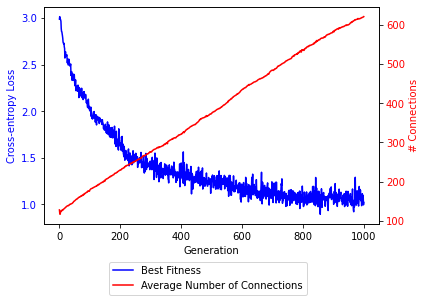

In [27]:
# Plot line for minimum fitness
fig, fit_ax = plt.subplots()
fit_line = fit_ax.plot(gen, fitness_best, "b-", label="Best Fitness")
fit_ax.set_xlabel("Generation")
fit_ax.set_ylabel(f"Cross-entropy Loss", color="b")
for tl in fit_ax.get_yticklabels():
    tl.set_color("b")

# Plot line for average total height
height_ax = fit_ax.twinx()
height_line = height_ax.plot(gen, conn_avg, "r-", label="Average Number of Connections")
height_ax.set_ylabel("# Connections", color="r")
for tl in height_ax.get_yticklabels():
    tl.set_color("r")

# Add legend
lines = fit_line + height_line
labs = [l.get_label() for l in lines]
fit_ax.legend(lines, labs, bbox_to_anchor=(0.8, -0.15))

# Show the result
plt.show()

## Inspecting the best individual

In [28]:
best_ind = hof[0]
print(best_ind)
print(f"Fitness of best individual: {best_ind.fitness}")

MultiClassTree with 191 hidden nodes and 564 connections, born in generation 857
Fitness of best individual: (0.8934939777439006, 0.6483384455870942)


##### Printing trees

In [29]:
# Print the trees of the best individual
for string in best_ind.get_strings():
    print(f"{string}\n")

linear(w, ARG32, ARG44, ARG48, ARG98, ARG149, ARG158, ARG219, ARG53, tanh(w, ARG50, ARG45, absolute(w, absolute(w, inverse(w, absolute(w, sine(w, linear(w, ARG81)), ARG78), sine(w, linear(w, ARG81))))), ARG49, ARG129, sine(w, linear(w, ARG81)), relu(w, tanh(w, inverse(w, relu(w, sine(w, linear(w, ARG81)), gaussian(w, ARG1))))), ARG76), ARG198, tanh(w, ARG85, ARG83, inverse(w, ARG3)), ARG96, tanh(w, linear(w, inverse(w, ARG129, ARG178, ARG194, ARG237, ARG211, ARG191), inverse(w, ARG131, ARG221), ARG131, relu(w, ARG229)), ARG229, ARG82, ARG27, ARG50), ARG226, ARG126, linear(w, ARG244, ARG34), sigmoid(w, tanh(w, ARG155, ARG134), tanh(w, ARG20)), ARG178)

linear(w, ARG43, ARG47, ARG87, ARG113, ARG128, ARG134, ARG223, ARG239, ARG252, linear(w, ARG249, ARG55), ARG141, ARG242, tanh(w, step(w, ARG214, ARG25, ARG226, inverse(w, ARG186)), ARG217, ARG247, linear(w, ARG100, ARG81, absolute(w, ARG112, ARG176), ARG112, ARG160, ARG206, ARG49, ARG141, ARG204, ARG99, absolute(w, ARG245)), ARG1, ARG8), 

##### Computing training & validation accuracy

In [30]:
# Retrieving predictions from an individual
def get_predictions(individual, X, weight):
    func = compile_multiclasstree(individual)
    predictions = []
    for i in range(X.shape[0]):
        outputs_i = func(weight, X[i])
        predictions.append(np.argmax(outputs_i))
    return predictions

In [31]:
# Compute accuracy of predictions
def compute_accuracy(Y_pred, Y_true):
    n_correct = np.sum(Y_pred == Y_true)
    return n_correct/Y_true.shape[0]

In [32]:
# Retrieve predictions of the best individual on the training and validation sets, for all weights
Y_train_pred = np.array([get_predictions(best_ind, X_train, w) for w in WEIGHTS_TO_TEST])
Y_test_pred = np.array([get_predictions(best_ind, X_test, w) for w in WEIGHTS_TO_TEST])

In [33]:
# Compute training accuracies for all weights and extract the best weight
train_accs = [compute_accuracy(Y_train_pred[i], Y_train) for i in range(len(WEIGHTS_TO_TEST))]
test_accs = [compute_accuracy(Y_test_pred[i], Y_test) for i in range(len(WEIGHTS_TO_TEST))]
best_weight_idx_train = np.argmax(train_accs)
best_weight_idx_test = np.argmax(test_accs)

# Print best training and validation accuracies of the best individual
print(f"Best training accuracy (weight {WEIGHTS_TO_TEST[best_weight_idx_train]}): {np.max(train_accs)}")
print(f"Best validation accuracy (weight {WEIGHTS_TO_TEST[best_weight_idx_test]}): {np.max(test_accs)}")

Best training accuracy (weight 2): 0.70325
Best validation accuracy (weight 2): 0.7


In [34]:
# Obtain majority votes (in case of a tie, use vote of the best classifier)
def get_majority_predictions(predictions):
    def _majority(l):
        return max(set(l), key=l.count)
    predictions = [_majority(list(predictions[:,i])) for i in range(predictions.shape[1])]
    return predictions

In [35]:
# Compute majority predictions for train and validation sets
Y_train_majpred = get_majority_predictions(Y_train_pred)
Y_test_majpred = get_majority_predictions(Y_test_pred)

# Print the accuracies of the majority votes
print(f"Majority training accuracy: {compute_accuracy(Y_train_majpred, Y_train)}")
print(f"Majority validation accuracy: {compute_accuracy(Y_test_majpred, Y_test)}")

Majority training accuracy: 0.6857333333333333
Majority validation accuracy: 0.6821


##### Confusion matrices

In [36]:
# Compute confusion matrices
cm_train_best = confusion_matrix(Y_train, Y_train_pred[best_weight_idx_train], labels=range(N_CLASSES_TO_USE))
cm_test_best = confusion_matrix(Y_test, Y_test_pred[best_weight_idx_test], labels=range(N_CLASSES_TO_USE))
cm_train_maj = confusion_matrix(Y_train, Y_train_majpred, labels=range(N_CLASSES_TO_USE))
cm_test_maj = confusion_matrix(Y_test, Y_test_majpred, labels=range(N_CLASSES_TO_USE))

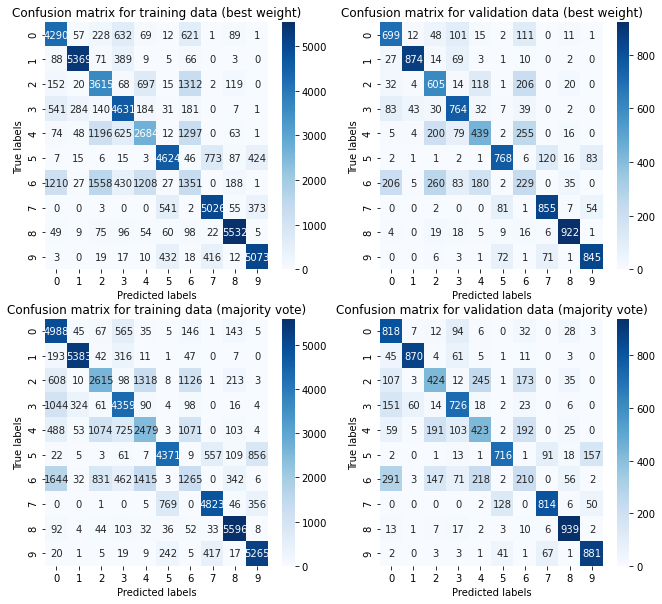

In [37]:
# Create figure
fig, ax = plt.subplots(2,2, figsize=(11,10))
ax = ax.ravel()

# Plot confusion matrix for training data using best weight
sns.heatmap(cm_train_best, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data (best weight)')

# Plot confusion matrix for validation data using best weight
sns.heatmap(cm_test_best, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for validation data (best weight)')

# Plot confusion matrix for training data using majority vote
sns.heatmap(cm_train_maj, annot=True, fmt='g', ax=ax[2], cmap="Blues")
ax[2].set_xlabel('Predicted labels')
ax[2].set_ylabel('True labels')
ax[2].set_title('Confusion matrix for training data (majority vote)')

# Plot confusion matrix for validation data using majority vote
sns.heatmap(cm_test_maj, annot=True, fmt='g', ax=ax[3], cmap="Blues")
ax[3].set_xlabel('Predicted labels')
ax[3].set_ylabel('True labels')
ax[3].set_title('Confusion matrix for validation data (majority vote)')

# Show the result
plt.show()

##### Used features

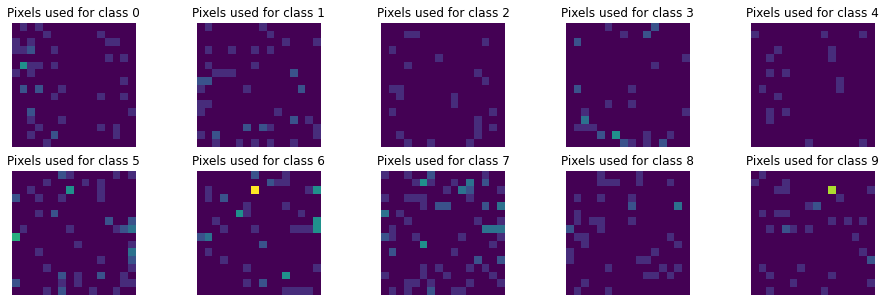

In [38]:
# Extract input tallies from best individual
input_tallies = []
for tree in best_ind.get_strings():
    inputs_used = list(map(int, re.findall("[0-9]+", tree)))
    input_tally = np.zeros(X_train.shape[1])
    for arg in inputs_used:
        input_tally[arg] += 1
    input_tallies.append(input_tally)

# Create plots of the inputs (pixels) used in the tree of the best individual for each class
# Note: for the best-looking plot, this implementation assumes that N_CLASSES_TO_USE is set to 10
fig, ax = plt.subplots(2, 5, figsize=(16,5))
ax = ax.ravel()
for i, tally in enumerate(input_tallies):
    img_shape = int(math.sqrt(X_train.shape[1]))
    ax[i].imshow(np.array(tally).reshape(img_shape, img_shape), clim=(0,np.max(input_tallies)))
    ax[i].axis("off")
    ax[i].set_title(f"Pixels used for class {i}")
plt.show()

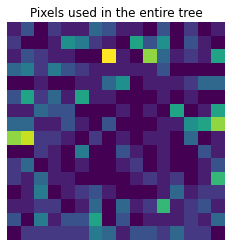

In [39]:
# Plot image of all inputs used in the tree
plt.imshow(np.sum(input_tallies, axis=0).reshape(16,16))
plt.axis("off")
plt.title("Pixels used in the entire tree")
plt.show()